# Geological Image Similarity Case Study
#### Problem Statement:
A geology research company wants to create a tool for identifying interesting patterns in their imagery data. This tool will possess a search capability whereby an analyst provides an image of interest and is presented with other images which are similar to it.
#### Objective:
Create the machine learning component for this image similarity application. The machine learning model should return the top K images that are most similar to this image based on a single image input.
#### Methodology:
1. Preprocess imagery to be utilized in a machine learing model.
    * Each image should be converted into a numeric array.
    * Each image array should then be transformed into a tensor in order to be fed into model.
2. Train Convolutional Neural Network (CNN) Model
    * Split dataset into training and test sets.
3. Extract image embeddings from model
    * Image embeddings will be used to help find the top K images that are most similar.
4. Utilize K-Nearest Neighbors (KNN) to find top K images that are most similar.
    * Image embeddings will be fed into a KNN model.

In [1]:
import os

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib.image as mpimg
from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

C:\Users\mwick\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


# Data Exploration and Manipulation



In [2]:
data_path = ".\geological_similarity"

# Get all filenames in folder: 
img_files = [os.path.join(path, name) for path, subdirs, files in os.walk(data_path) for name in files]
print('dataset length = ', len(img_files))

dataset length =  29998


The data set contains 29998 images. Each image is divided among 6 geological classifications. First, it must be determined if the dataset in balanced before a model can be trained on the data. If the dataset is Imbalanced, then techniques such as oversampling, undersampling, feature selection, or cost-sensitive learning can be used to convert the dataset into a balanced data set. By looking at the number of images in each set, it is apparent that the geological data set is balanced. There are close to 5000 images in each category. The dataset can be used as is.

In [3]:
folders = [f.path for f in os.scandir(data_path) if f.is_dir()]
for folder in folders:
    print(folder.split('\\')[-1], ':', len(os.listdir(folder)), 'images')

andesite : 5000 images
gneiss : 5000 images
marble : 4998 images
quartzite : 5000 images
rhyolite : 5000 images
schist : 5000 images


Before moving on to transforming the data into numerical arrays, I wanted to preview the images in each category. Visually, it is not apparent which images within each category are more similar than others. Gneiss and schist look similar enough that I would not be able to separate the two by eye. This gives the impression that the factors are latent. 

Given that the features are latent (i.e, hidden), then features within each category can be learned using a deep learning algorithm such as CNN. 

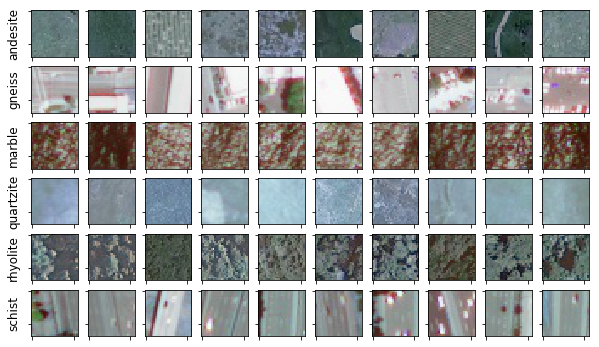

In [4]:
n_show = 10

folders = [f.path for f in os.scandir(data_path) if f.is_dir()]

fig, axes = plt.subplots(len(folders), n_show, figsize = (n_show,6))

for row_idx, subfolder in enumerate(folders):    
    filenames = [f.path for f in os.scandir(subfolder)]   
    files_to_preview = random.sample(filenames, n_show)
    for col_idx, path in enumerate(files_to_preview):
        image = mpimg.imread(path)
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_xticklabels([])
        axes[row_idx, col_idx].set_yticklabels([])
        
for ax, row in zip(axes[:,0], folders):
    ax.set_ylabel(row.split('\\')[-1], rotation=90, size='large')

plt.show()

The GeologicalDataset class below takes the directory with all the images and then transforms it into a pytorch dataset to be ingested into the CNN model. 

In [5]:
# Create Torch Dataset from input data:
class GeologicalDataset(Dataset):
    """Geological dataset."""

    def __init__(self, data_path, transform=None, train=True):
        """
        Args:
            data_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_path = data_path
        self.transform = transform
        self.train = train
        
        img_names_list = [os.path.join(path, name) for path, subdirs, files in os.walk(data_path) for name in files]
        label_to_idx = {
            'andesite': 0,
            'gneiss': 1,
            'marble': 2,
            'quartzite': 3,
            'rhyolite': 4,
            'schist': 5
            }
        labels_list = [label_to_idx[os.path.join(path, name).split('\\')[-2]]
                       for path, subdirs, files in os.walk(data_path)
                       for name in files
                      ]
        
        img_names_train, img_names_test, labels_train, labels_test = train_test_split(
            img_names_list,
            labels_list,
            test_size=0.2,
            shuffle=True,
            random_state=42
        )

        if self.train == True:
            self.img_names = img_names_train
            self.labels = labels_train
        else:
            self.img_names = img_names_test
            self.labels = labels_test
            
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):        
        image = mpimg.imread(self.img_names[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label
        return image, label

Before creating the test and training dataset, it is ideal to find the mean and standard devation (std) of the data. The mean and std will be used to normalize the dataset. Normalizing the data allows for less frequent non-zero gradients during training. This implies that the network will learn faster. I have calculated the mean and standard deviation of the dataset below. 

In [6]:
train_transform = T.Compose([
    T.ToPILImage(), 
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.ToTensor(),

])

train_set = GeologicalDataset(data_path, transform = train_transform, train = True)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=100000)
for images, labels in train_loader:
    for channel in range(3):
        print('channel', channel, 'mean', torch.mean(images[:,channel,:,:]), 'std', torch.std(images[:,channel,:,:]))

channel 0 mean tensor(0.5080) std tensor(0.1843)
channel 1 mean tensor(0.5198) std tensor(0.1990)
channel 2 mean tensor(0.5199) std tensor(0.2191)


Now that the mean and standard deviation are known for each channel, the training and test data can be loaded and transformed to be used in the CNN. The training and test split is 80% training and 20% test. This gives 23998 images in the training set and 6000 images in the test set.

In [7]:
train_transform = T.Compose([
    T.ToPILImage(), 
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.52, 0.52],
                         std=[0.18, 0.2, 0.2])
])

test_transform = T.Compose([
    T.ToPILImage(), 
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.52, 0.52],
                         std=[0.18, 0.2, 0.2])
])

train_set = GeologicalDataset( data_path,transform=train_transform, train = True)
test_set = GeologicalDataset(data_path,transform=test_transform, train = False)

print('train_set:', len(train_set))
print('test_set:', len(test_set))
batch_size = 1024

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

train_set: 23998
test_set: 6000


# Training the CNN
## Why use CNN?
CNNs are composed of multiple layers of neurons. When an image is input into a CNN, each layer generates several activation functions that are passed to the next layer. The first layers of a CNN extract the features of the input image. These features can be used to determine image similarity by being fed into a KNN. This can be done by pulling out the image embeddings from the CNN. Before the embeddings can be pulled out, the model must be trained on the training dataset. The results can be seen below.

In [8]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=512),
            nn.Dropout(0.25),
            nn.Linear(in_features=512, out_features=128),
            )

        self.linear = nn.Linear(in_features=128, out_features=6)
        
    def forward(self, x):
        embedding = self.nn(x)
        x = self.linear(embedding)
        return embedding, x
        
model = CNN()
print(model)

CNN(
  (nn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=512, bias=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): Linear(in_features=512, out_features=128, bias=True)
  )
  (linear): Linear(in_features=128, out_features=6, bias=True)
)


In [13]:
model = CNN()

loss_func = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Below are the results of training the CNN. 10 epochs took approximately 10 mins to train, and had approximately 97% train and test accuracy. However, since the CNN is not being used to classify each of the images into their given category, there is no reason to use the CNN to predict the image classification of the test images. Instead, the image embeddings are pulled out of the model. These embeddings will allow the KNN algorithm to find images that are similar to one another.

In [14]:
%%time

                                  
num_epochs = 10

for epoch in range(num_epochs):
    
    train_accuracy_epoch=[]
    for train_batch_idx, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        _, outputs = model(images)        
        predictions = torch.max(outputs, 1)[1]
        train_accuracy = accuracy_score(predictions, labels)
        train_accuracy_epoch.append(train_accuracy)
        loss = loss_func(outputs, labels)                
        loss.backward()        
        optimizer.step()
    
    avg_train_accuracy_epoch = np.mean(train_accuracy_epoch)
    
          
    # At the end of epoch - evaluate test set accuracy
    test_accuracy_epoch=[]
    for test_batch_idx, (images, labels) in enumerate(test_loader):
        model.eval()       
        _, outputs = model(images)
        predictions = torch.max(outputs, 1)[1]
        test_accuracy = accuracy_score(predictions, labels)
        test_accuracy_epoch.append(test_accuracy)        
    
    avg_test_accuracy_epoch = np.mean(test_accuracy_epoch)
    
    
    print('Epoch: ', epoch,
          '  Train accuracy:', round(avg_train_accuracy_epoch,4),
          '  Test accuracy:', round(avg_test_accuracy_epoch,4)
          )

Epoch:  0   Train accuracy: 0.7898   Test accuracy: 0.8394
Epoch:  1   Train accuracy: 0.9272   Test accuracy: 0.9275
Epoch:  2   Train accuracy: 0.9428   Test accuracy: 0.9455
Epoch:  3   Train accuracy: 0.9475   Test accuracy: 0.9491
Epoch:  4   Train accuracy: 0.9535   Test accuracy: 0.9429
Epoch:  5   Train accuracy: 0.9617   Test accuracy: 0.9555
Epoch:  6   Train accuracy: 0.9624   Test accuracy: 0.9631
Epoch:  7   Train accuracy: 0.9654   Test accuracy: 0.9697
Epoch:  8   Train accuracy: 0.9686   Test accuracy: 0.9646
Epoch:  9   Train accuracy: 0.9708   Test accuracy: 0.9735
Wall time: 9min 9s


In [15]:
def get_embedding(file, model):
    image = mpimg.imread(file)
    image = test_transform(image)
    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        emb, _ = model(image)
    return emb.numpy()

In [16]:
image_embeddings = np.zeros((len(img_files), 128))
for idx, file in enumerate(img_files):
    image_embeddings[idx] = get_embedding(file, model=model)
print(image_embeddings.shape)

(29998, 128)


# Computing Image Similarity using K Nearest Neighbor
KNN is a model that is used to find the closest approximate neighbors for input data. For finding similar images, the images must be converted into vectors. The neighbors are identified by comparing the input vector with the trained model in a multidimensional plane. KNN measure the distance between two vectors to determine how similar they are to each other. The distance between two neighbors can be calculated many ways:
1. Euclidean Distance
    * Measure of the true straight line distance between two points in Euclidean space
2. Cosine Distance
    * Used mainly to calculate similarity between two vectors. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in the same direction
3. Manhattan Distance.
    * The distance between two points is the sum of the absolute differences of their Cartesian coordinates.
4. Hamming Distance
    * Metric for comparing two binary data strings. While comparing two binary strings of equal length, Hamming distance is the number of bit positions in which the two bits are different
    
Due to the fact that similarity between two vectors is what is needed, I decided that the cosine distance would be the best method to use for the KNN.

In [17]:
def compute_similar_images(image, num_images, embedding):

    # Get the embedding for this image
    emb = get_embedding(random_img, model=model)
#     print(emb.shape)

    flattened_embedding = emb.reshape((emb.shape[0], -1))
#     print(flattened_embedding.shape)

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
#     print(indices_list)
    return indices_list

In [18]:
def plot_similar_images(indices_list):
    indices = indices_list[0]
    for index in indices:
        img_name = img_files[index]
        img_path = os.path.join(img_name)
        print(img_path)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.show()

# Top K Images that are Most Similar
The cell below will choose an random image from the dataset, and use the KNN model to choose the K most similar images in the data set. It is apparent by each of the images below and the file paths of each of the images that the KNN model performs well when finding the top K images that are most similar to a given image.

.\geological_similarity\andesite\MUVT3.jpg


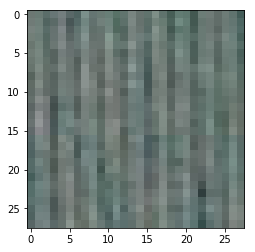

.\geological_similarity\andesite\0SD5F.jpg


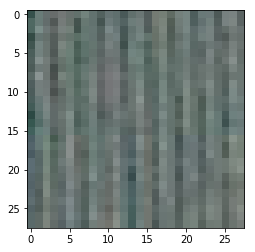

.\geological_similarity\andesite\UU4BF.jpg


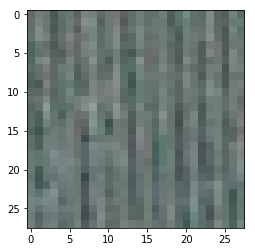

.\geological_similarity\andesite\QECB7.jpg


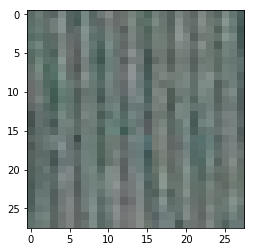

.\geological_similarity\andesite\98FRD.jpg


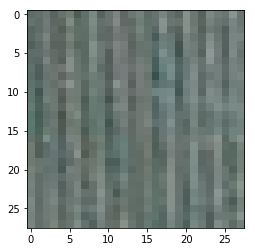

.\geological_similarity\andesite\TLXX2.jpg


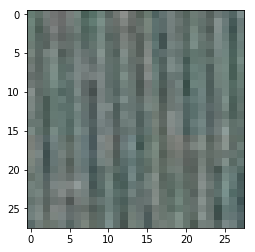

.\geological_similarity\andesite\0FDJG.jpg


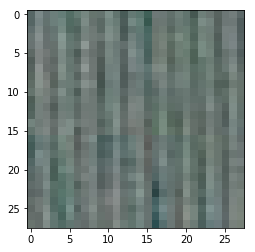

.\geological_similarity\andesite\O6PRS.jpg


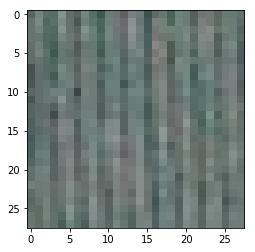

.\geological_similarity\andesite\GIMSP.jpg


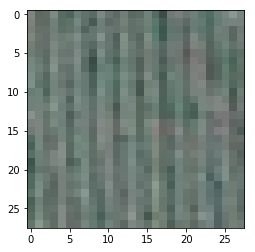

.\geological_similarity\andesite\QEC1D.jpg


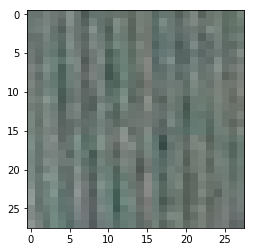

In [19]:
# Select random image from test
k=10
random_img = random.choice(img_files)
indices_list  = compute_similar_images(random_img, k, image_embeddings)
plot_similar_images(indices_list)